In [1]:
!pip install "git+https://github.com/DavidLandup0/deepvision@nerf"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DavidLandup0/deepvision (to revision nerf) to /tmp/pip-req-build-cwvhq_yj
  Running command git clone --filter=blob:none --quiet https://github.com/DavidLandup0/deepvision /tmp/pip-req-build-cwvhq_yj
  Running command git checkout -b nerf --track origin/nerf
  Switched to a new branch 'nerf'
  Branch 'nerf' set up to track remote branch 'nerf' from 'origin'.
  Resolved https://github.com/DavidLandup0/deepvision to commit ada95b85b051aa08b6a9aded11f7313fcfbea125
  Preparing metadata (setup.py) ... done


In [ ]:
import deepvision
import tensorflow as tf
import torch

In [3]:
config = {
    'img_height': 100,
    'img_width': 100,
    'pos_embed': 16,
    'num_ray_samples': 32,
    'batch_size': 4
}

In [4]:
num_pos = config['img_height'] * config['img_width'] * config['num_ray_samples']
input_features = 6 * config['pos_embed'] + 3

# Training a Neural Radiance Field (NeRF) Model with TensorFlow and DeepVision

Let's first train a NeRF model with TensorFlow/Keras. We'll start off by loading the Tiny_NeRF dataset, optionally specifying the number of positional embeddings and number of ray samples (defaulting to the official implementation).

You can reduce both the positional embeddings and number of ray samples to make the dataset easier to fit on some machines, and the model you feed the data into will inherit the configuration. When rendering scenes using the visualization utilities, make sure to pass the same number of positional embeddings and ray samples you specified when creating the dataset:

In [5]:
train_ds, valid_ds = deepvision.datasets.load_tiny_nerf(pos_embed=config['pos_embed'],            # Optional, defaults to 16
                                                        num_ray_samples=config['num_ray_samples'],# Optional, defaults to 32
                                                        save_path='tiny_nerf.npz',
                                                        validation_split=0.2,
                                                        backend='tensorflow') 

train_ds = train_ds.batch(config['batch_size']).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(config['batch_size']).prefetch(tf.data.AUTOTUNE)

print('Train dataset length:', len(train_ds))
print('Valid dataset length:', len(valid_ds))

Dataset already exists under /root/deepvision_datasets/tiny_nerf/tiny_nerf.npz. Skipping download and re-using existing data. If you want to download again, set `download=True`.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Train dataset length: 21
Valid dataset length: 6


With the dataset loaded and batched, let's instantiate a NeRF model. DeepVision offers:

- NeRFTiny
- NeRFSmall
- NeRFMedium
- NeRF
- NeRFLarge

Each NeRF model type exposes a different model, with varying depth (number of layers) and width (number of units in the dense/linear layers). `NeRF` is equal to the official implementation, but requires a fair bit of VRAM, so smaller variants are exposed to make training, testing and getting familiar with NeRFs easier:

In [6]:
model = deepvision.models.NeRFMedium(input_shape=(num_pos, input_features), 
                                   backend='tensorflow')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.MeanSquaredError())

In [7]:
model.summary()

Model: "ne_rftf"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320000, 99)  0           []                               
                                ]                                                                 
                                                                                                  
 dense (Dense)                  (None, 320000, 128)  12800       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 320000, 128)  16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 320000, 128)  16512       ['dense_1[0][0]']          

The model is automatically trained with a PSNR (Peak Signal-to-Noise Ratio) metric, which can be used as an image quality metric, and was used in the official paper/implementation: 

In [8]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau()]

model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=callbacks)

Epoch 1/20
21/21 [==============================] - 51s 2s/step - loss: 0.0644 - psnr: 12.3432 - val_loss: 0.0603 - val_psnr: 12.4369 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - 37s 2s/step - loss: 0.0469 - psnr: 13.7468 - val_loss: 0.0365 - val_psnr: 14.4763 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - 38s 2s/step - loss: 0.0316 - psnr: 15.2550 - val_loss: 0.0295 - val_psnr: 15.3054 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - 39s 2s/step - loss: 0.0276 - psnr: 15.8053 - val_loss: 0.0256 - val_psnr: 15.8896 - lr: 0.0010
Epoch 5/20
21/21 [==============================] - 38s 2s/step - loss: 0.0241 - psnr: 16.3510 - val_loss: 0.0223 - val_psnr: 16.4504 - lr: 0.0010
Epoch 6/20
21/21 [==============================] - 37s 2s/step - loss: 0.0217 - psnr: 16.8189 - val_loss: 0.0206 - val_psnr: 16.7843 - lr: 0.0010
Epoch 7/20
21/21 [==============================] - 38s 2s/step - loss: 0.0198 - psnr: 17.1877 - val_loss: 0.0181 - va

To visualize the results, we'll leverage the `volumetric_utils` module, which exposes a `nerf_render_image_and_depth_{backend}` method. The method accepts the model to perform inference, as well as the flattened rays, 3D query points (t_vals), image heigth/width and the number of ray samples, and returns:

- An RGB image render
- A depth map
- An accuracy map

With those, we can plot the images, depth maps and accuracy maps of a single batch easily:

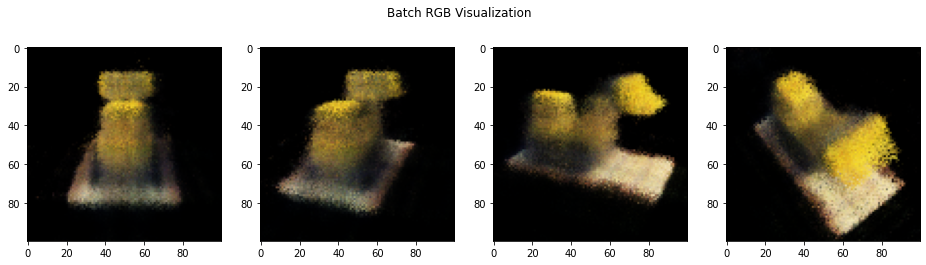

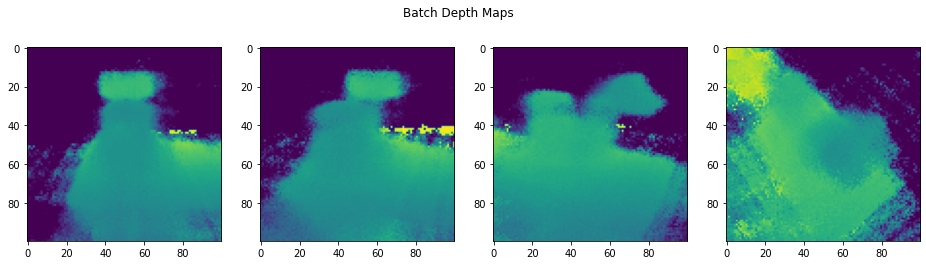

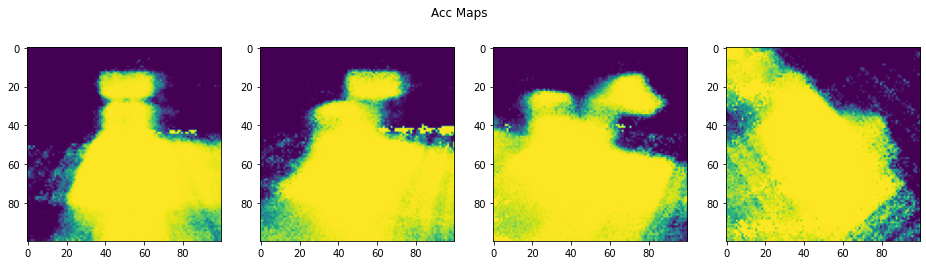

In [9]:
import matplotlib.pyplot as plt
from deepvision.models.volumetric.volumetric_utils import nerf_render_image_and_depth_tf

for batch in train_ds.take(1):
    (images, rays) = batch
    (rays_flat, t_vals) = rays
    
    image_batch, depth_maps, acc_maps = nerf_render_image_and_depth_tf(model=model, 
                                                                       rays_flat=rays_flat, 
                                                                       t_vals=t_vals,
                                                                       img_height=config['img_height'], 
                                                                       img_width=config['img_width'], 
                                                                       num_ray_samples=config['num_ray_samples'])
    
    fig, ax = plt.subplots(1, config['batch_size'], figsize=(16, 4))
    fig.suptitle('Batch RGB Visualization')
    for index, img in enumerate(tf.squeeze(image_batch[0])):
        ax[index].imshow(img)

    fig, ax = plt.subplots(1, config['batch_size'], figsize=(16, 4))
    fig.suptitle('Batch Depth Maps')
    for index, img in enumerate(tf.squeeze(depth_maps[0])):
        ax[index].imshow(img)

    fig, ax = plt.subplots(1, config['batch_size'], figsize=(16, 4))
    fig.suptitle('Acc Maps')
    for index, img in enumerate(tf.squeeze(acc_maps[0])):
        ax[index].imshow(img)

In [10]:
# Release GPU to avoid OOM due to large tensors being trained with NeRF
from numba import cuda
cuda.select_device(0)
cuda.close()

# Training a Neural Radiance Field (NeRF) Model with PyTorch and DeepVision

Now, let's take a look at a PyTorch example, which exposes the exact same API as the previous example, but allows you to train the model in the PyTorch/Lightning ecosystem. 

We'll start off by loading the Tiny_NeRF dataset, optionally specifying the number of positional embeddings and number of ray samples (defaulting to the official implementation).

You can reduce both the positional embeddings and number of ray samples to make the dataset easier to fit on some machines, and the model you feed the data into will inherit the configuration. When rendering scenes using the visualization utilities, make sure to pass the same number of positional embeddings and ray samples you specified when creating the dataset:

In [12]:
import pytorch_lightning as pl

import logging
logging.getLogger("lightning").setLevel(logging.ERROR)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds, valid_ds = deepvision.datasets.load_tiny_nerf(pos_embed=config['pos_embed'],
                                                        num_ray_samples=config['num_ray_samples'],
                                                        save_path='tiny_nerf.npz',
                                                        validation_split=0.2,
                                                        backend='pytorch') 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config['batch_size'], drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=config['batch_size'], drop_last=True)

print('Train dataset length:', len(train_ds))
print(train_loader)

print('Valid dataset length:', len(valid_ds))
print(valid_loader)

Dataset already exists under /root/deepvision_datasets/tiny_nerf/tiny_nerf.npz. Skipping download and re-using existing data. If you want to download again, set `download=True`.
Train dataset length: 84
Valid dataset length: 22


With the dataset loaded and batched, let's instantiate a NeRF model. DeepVision offers:

- NeRFTiny
- NeRFSmall
- NeRFMedium
- NeRF
- NeRFLarge

Each NeRF model type exposes a different model, with varying depth (number of layers) and width (number of units in the dense/linear layers). `NeRF` is equal to the official implementation, but requires a fair bit of VRAM, so smaller variants are exposed to make training, testing and getting familiar with NeRFs easier:

In [13]:
pt_model = deepvision.models.NeRFMedium(input_shape=(num_pos, input_features), backend='pytorch')

pt_model

NeRFPT(
  (layers): ModuleList(
    (0): Linear(in_features=99, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=227, out_features=128, bias=True)
  )
  (psnr): PeakSignalNoiseRatio()
  (output): Linear(in_features=128, out_features=4, bias=True)
)

The model is automatically trained with a PSNR (Peak Signal-to-Noise Ratio) metric, which can be used as an image quality metric, and was used in the official paper/implementation: 

In [14]:
# Define loss function and optimizer
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(pt_model.parameters(), 1e-3)

# Compile
pt_model.compile(loss=loss, optimizer=optimizer)

# Train
trainer = pl.Trainer(accelerator=device, max_epochs=20)
trainer.fit(pt_model, train_loader, valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type                 | Params
------------------------------------------------
0 | layers | ModuleList           | 108 K 
1 | psnr   | PeakSignalNoiseRatio | 0     
2 | output | Linear               | 516   
3 | loss   | MSELoss              | 0     
------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.434     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 4, 100, 100, 3])) that is different to the input size (torch.Size([4, 100, 100, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


To visualize the results, we'll leverage the `volumetric_utils` module, which exposes a `nerf_render_image_and_depth_{backend}` method. The method accepts the model to perform inference, as well as the flattened rays, 3D query points (t_vals), image heigth/width and the number of ray samples, and returns:

- An RGB image render
- A depth map
- An accuracy map

With those, we can plot the images, depth maps and accuracy maps of a single batch easily:

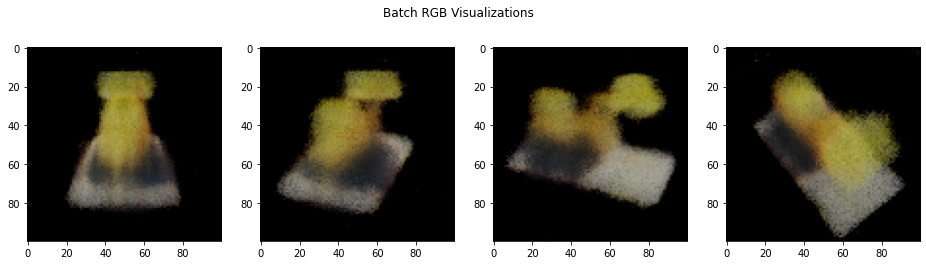

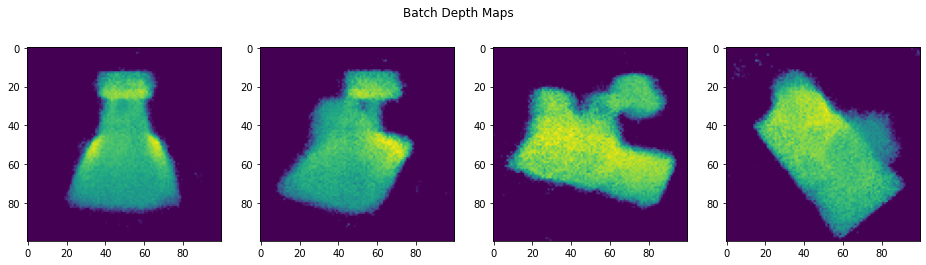

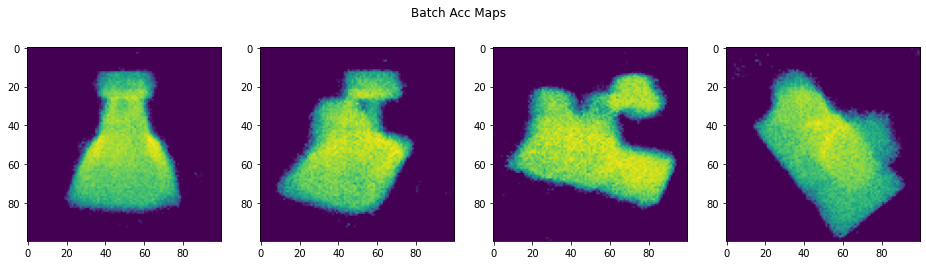

In [19]:
import matplotlib.pyplot as plt
from deepvision.models.volumetric.volumetric_utils import nerf_render_image_and_depth_pt


batch = next(iter(train_loader))
(images, rays) = batch["image"], batch["rays"]
(rays_flat, t_vals) = rays

rays_flat = rays_flat.to(device)
t_vals = t_vals.to(device)
pt_model.to(device)

image_batch, depth_maps, acc_maps = nerf_render_image_and_depth_pt(model=pt_model, 
                                     rays_flat=rays_flat, 
                                     t_vals=t_vals,
                                     img_height=config['img_height'], 
                                     img_width=config['img_width'], 
                                     num_ray_samples=config['num_ray_samples'])

fig, ax = plt.subplots(1, config['batch_size'], figsize=(16, 4))
fig.suptitle('Batch RGB Visualizations')
for index, img in enumerate(image_batch[0].squeeze()):
    ax[index].imshow(img.detach().cpu().numpy())

fig, ax = plt.subplots(1, config['batch_size'], figsize=(16, 4))
fig.suptitle('Batch Depth Maps')
for index, img in enumerate(depth_maps[0].squeeze()):
    ax[index].imshow(img.detach().cpu().numpy())

fig, ax = plt.subplots(1, config['batch_size'], figsize=(16, 4))
fig.suptitle('Batch Acc Maps')
for index, img in enumerate(acc_maps[0].squeeze()):
    ax[index].imshow(img.detach().cpu().numpy())